In this first post we will be facing the problem of denoising images. People love taking photos, but during the image acquisition process, image gets contaminated by noise. And this happens always. There has been a lot of efforts to mitigate noise effects on images by means of filtering. Normally noise is highly noticeable in high frequencies, so low pass filters are normally used to mitigate undesired effects:

- Linear low pass filtering. The most common is the gaussian filter, but normally those filters also add some unwanted distortion around image edges and textures
- Non-linear filters. We find here the bilateral [1] or the non local means filters [2], among others. The non linearity is introduced to avoid destroying image information at high frequencies
- Variational Methods. Namely the Rudin-Osher-Fatemi method [3], which attempts to approximate the original image by minimizing a energy method.

The list goes on and on, and a comprehensive analysis is done in [4]. Here we are going to focus on non local means (NLM), mainly for two reasons:

- It gives one of the best results
- The idea is really simple but powerful

Let's explain the intuition behind the algorithm

### The NLM algorithm

The origin comes from the fact that in an image there is a lot of redundancy. For example in this image:

<img src="images/lena_marked.jpg" width=30% align="middle"> </img>

The squares marked with the same color are on similar images areas. So, why not use all this information to infer values of the pixel? The idea comes from the Markov Random Field theory which, intuitively, claims that the $pdf$ of a pixel given it´s neighborhood should be similar for similar neighborhoods.

Essentially, the algorithm modifies each pixel value by a weighted average of all the other pixels, and the weight values are determined by neighborhood similarity:

$$ I(p) = \frac{1}{Z} \sum_{q \in \cal{N}} w_{pq}I(q) $$

The variable $Z = \sum w_{pq}$ is a normalization factor and $\cal{N}$ is a neighborhood around the pixel $p$. The weights $w_{pq}$ are computed as:

$$ w_{pq} = \exp \left(- \frac{\|\Omega(I(p)) -  \Omega(I(q))\|^2}{h^2} \right) $$

where $\Omega(p)$ indicates a winow centered on pixel $p$. Translating that math into pseudo-code, we get something like this:

In [ ]:
for x,y in Image:
    total_color = 0
    Z = 0
    
    for xp,yp in BigNeighborhood(x,y):
        difference = norm(SmallNeighborhood(x,y) - SmallNeighborhood(xp,yp))
        w = exp(-difference/h^2)
        total_color = total_color + w*I(xp, yp)
        
    I(x,y) = color / Z

Examining the algorithm closer, you will see quickly that these algorithm needs a LOT of iterations. We are going to explore two ways to deal with NLM and its computing needs.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
from skimage import data_dir
from skimage.transform import resize
import time

## Loading images and adding noise

We are gong to work with the famous Lena image. This is just for convenience, but if we really wanted to verify the results of our approaches we should try and test the algorithms against a handfull of images. For now, one is good. Let's load the image and produce some artifical gaussian additive noise:

In [3]:
noise_var = np.logspace(0, 2, 5)

lena = io.ImageCollection(data_dir + "/lena.png")[0].astype(np.float) / 255.0
lena = resize(lena, (lena.shape[0]/2, lena.shape[1]/2))
lena = color.rgb2lab(lena)
lena = lena[:,:,0]

noisy = []
for sigma2 in noise_var:
    noise = np.random.normal(0, np.sqrt(sigma2), lena.shape)
    n = lena + noise
    # avoid going over bounds
    n[n > 100] = 100
    n[n < 0] = 0
    noisy.append(n)

### Measuring image quality

Before digging into the actual problem, we need a measure to know the performance of our algorithm. Althought there is a lot of measures out there to measure image quality, we will stick with the simplest one, the PSNR: 

$$PSNR(I_0, I) = 10\log\frac{MAX^2}{MSE(I_0,I)}$$

Where $I_0$ is our original image and $I$ is the denoised image. $MAX$ is the maxmimum value the signal can get. In python code, we can define it as:

In [4]:
def PSNR(original, noisy, peak=100):
    mse = np.mean((original-noisy)**2)
    return 10*np.log10(peak*peak/mse)

Below are shown several images with differents amount of noise:

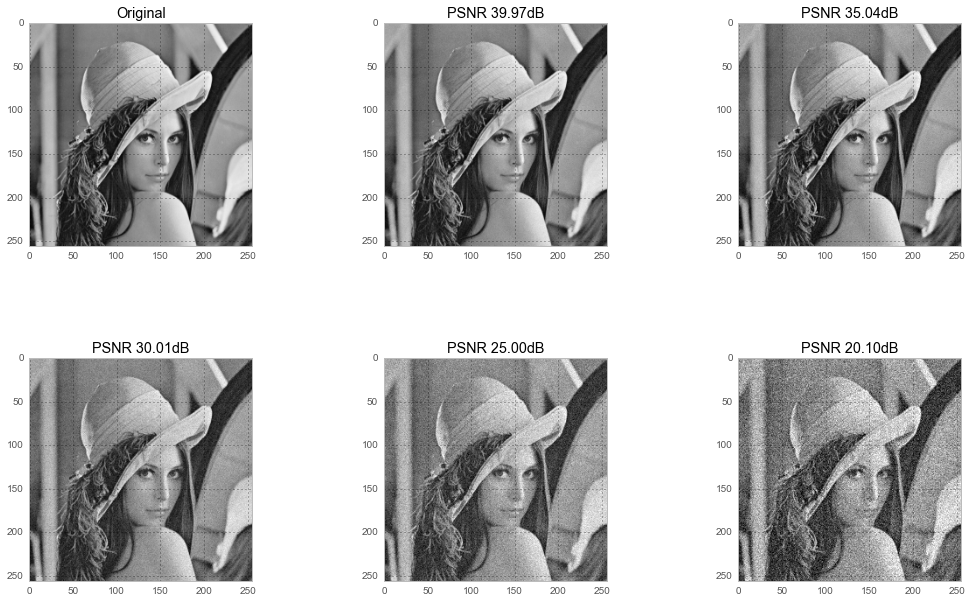

In [5]:
plt.figure(figsize=(18,10))

plt.subplot(2,3,1)
plt.imshow(lena,cmap='gray')
plt.title("Original")
for i,n in enumerate(noisy):
    plt.subplot(2,3,i+2)
    plt.title("PSNR {0:.2f}dB".format(PSNR(lena, n)))
    plt.imshow(n,cmap='gray')

It should be noted that an image with a PSNR higher that $35dB$ can be considered of high quality. Definitely, the last image looks pretty bad, it would be nice to see if we can improve it's quality.

## A naive implementation

Following the algorithm definition, we can translate directly the NLM maths to real code, by doing:

* Loop over each pixel $p$
* For each $p$ loop over all other pixels $q$ to compare patches
* Compute each patch centered at $q$ to a patch centered $p$
* Weight each patch accordingly and compute the weighted mean

There is mainly one big issue with this approach: the run time. For a $N\times M$ image, the naive implementation runs in $O(N^4D^2)$ where $D$ is the width of the patches we are comparing. This is clearly not feasible for even medium-sized images.

A trivial solution is to limit the search space on $q$ and, instead of looping over the whole image, just look for similar patches in a window of size $W$. Then the algorithm runs in $O(N^2W^2D^2)$ which is not too bad, but it can still give you high processing times for a single image.

Here is the naïve implementation:

In [6]:
from functools import reduce, partial

def _distance(values, pixel_window, h2, Nw):
    patch_window, central_diff = values

    diff = np.sum((pixel_window - patch_window) ** 2)
    # remove the central distance from the computation
    diff -= central_diff

    w = np.exp(-diff / (h2 * Nw))

    # return the color of the pixel and the weight associated with the patch
    nr, nc = patch_window.shape
    return w * patch_window[nr / 2, nc / 2], w

def nonlocalmeans_naive(img, n_big=20, n_small=5, h=10):
    new_n = np.zeros_like(img)

    Nw = (2 * n_small + 1) ** 2
    h2 = h * h
    n_rows, n_cols = img.shape

    # precompute the coordinate difference for the big patch
    D = range(-n_big, n_big + 1)
    big_diff = [(r, c) for r in D for c in D if not (r == 0 and c == 0)]

    # precompute coordinate difference for the small patch
    small_rows, small_cols = np.indices((2 * n_small + 1, 2 * n_small + 1)) - n_small

    padding = n_big + n_small
    n_padded = np.pad(img, padding, mode='reflect')

    for r in range(padding, padding + n_rows):
        for c in range(padding, padding + n_cols):
            pixel_window = n_padded[small_rows + r, small_cols + c]

            # construct a list of patch_windows
            windows = [n_padded[small_rows + r + d[0], small_cols + c + d[1]] for d in big_diff]

            # construct a list of central differences
            central_diffs = [(n_padded[r, c] - n_padded[r + d[0], c + d[1]]) for d in big_diff]

            distance_map = partial(_distance, pixel_window=pixel_window, h2=h2, Nw=Nw)
            distances = map(distance_map, zip(windows, central_diffs))

            total_c, total_w = reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]), distances)
            new_n[r - padding, c - padding] = total_c / total_w

    return new_n

Here we implemented the averaging color part using a map-reduce approach, which allows us to avoid 'for's on the python code (which are really slow) and can also be parallelized if we used some packages like multiprocessing.

**Note to multithreading** It turns out python is really bad at multithreading due to the GIL. So, instead of multiple threads, python spawns multiple processes to do parallel work. Spawning multiple processes is quite expensive, so in our case a multiprocessing pool for map() just made things slower. 

### A way to estimate noise

All the above is what we really need to denoise an image using NLM. But, what about the parameters? Why is the n_big = 20, n_small = 5 and h=10? Well, here is the explanation and some improvements:

- n_big: related to the big neighborhood to search for patches. The bigger, the better, but more CPU is needed. 
- n_small: related to the patch size when comparing similar neighborhoods. Here we should find a compromise between CPU and signal stationarity. We can´t chose a very big patch because the all patches will be different. We cannot choose a small patch either, because otherwise all patches will be similar. Normal values can range from 3 to 10.
- h: this is the constant used to control patch difference. It is known that it is closely related to the noise variance $\sigma^2$ present on image, and it may depend from pixel to pixel. Normally it is set at $K\sigma$ where K is $(7,10)$

Of course, here we know the amount the noise we have on each image, but normally this is not the case. We, however, can produce a rough noise estimate $\widehat{\sigma}$by trying to predict an optimal linear low pass filter that minimizes the square error. Since we know that a linear low pass filter will treat high "legitimate" high frequencies as noise, and thus $\widehat{\sigma} > \sigma$, we will then set $h=2*\widehat{\sigma}$.

Here is the code to estimate $\widehat{\sigma}$ using linear regression:

In [64]:
def estimate_noise(img):
    upper = img[:-2, 1:-1].flatten()
    lower = img[2:, 1:-1].flatten()
    left = img[1:-1, :-2].flatten()
    right = img[1:-1, 2:].flatten()
    central = img[1:-1, 1:-1].flatten()
    U = np.column_stack((upper, lower, left, right))
    c_estimated = np.dot(U, np.dot(np.linalg.pinv(U), central))
    error = np.mean((central - c_estimated)**2)
    sigma = np.sqrt(error)
    return sigma

In [89]:
sigmas = []
for i,n in enumerate(noisy):
    sigma = estimate_noise(n)
    sigmas.append(sigma)
    print("Estimated noise is {0:.4f}, real noise is {1:.4f}".format(sigma, np.sqrt(noise_var[i])))
    

Estimated noise is 2.8208, real noise is 1.0000
Estimated noise is 3.3017, real noise is 1.7783
Estimated noise is 4.4407, real noise is 3.1623
Estimated noise is 6.8896, real noise is 5.6234
Estimated noise is 11.4688, real noise is 10.0000


We have everything! Finally!
Let's apply the NLM filter to those noisy images:

PSNR before 30.0367 - PSNR after denoising 32.9163 - tool 257.8 secs
PSNR before 30.0367 - PSNR after denoising 32.3311 - tool 254.8 secs
PSNR before 30.0367 - PSNR after denoising 31.0766 - tool 260.7 secs
PSNR before 30.0367 - PSNR after denoising 29.0808 - tool 265.2 secs
PSNR before 30.0367 - PSNR after denoising 26.4586 - tool 256.1 secs


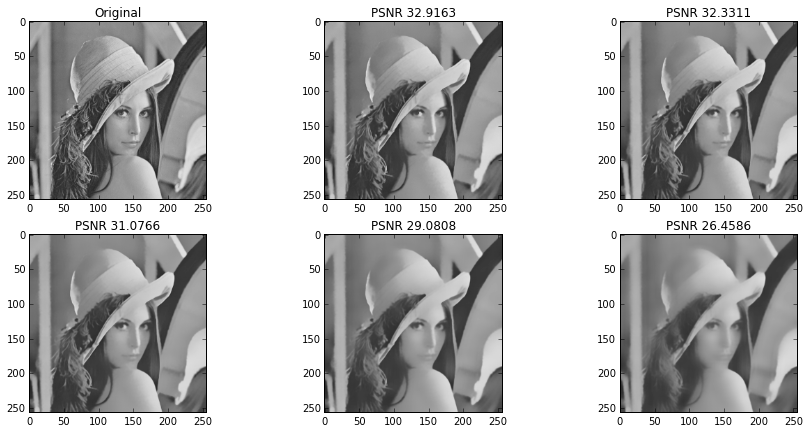

In [94]:
denoised_naive = []
plt.figure(figsize=(15,7))
plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(lena, vmin=0, vmax=100, cmap='gray')
for i,n in enumerate(noisy):
    start = time.time()
    denoised = nonlocalmeans_naive(noisy[2], n_big=7, n_small=1, h=2*sigmas[i])
    end = time.time()
    secs = end-start
    denoised_naive.append(denoised)
    oPSNR = PSNR(lena, noisy[i])
    dPSNR = PSNR(lena, denoised)
    print("PSNR before {0:.4f} - PSNR after denoising {1:.4f} - took {2:.1f} secs".format(oPSNR, dPSNR, secs))
    plt.subplot(2,3,i+2)
    plt.title("PSNR {0:.4f}".format(dPSNR))
    plt.imshow(denoised, vmin=0, vmax=100, cmap='gray')

Uh... it seems that our filter has some problems on high noise, and it takes a long time.

### Can we do it better? 

We are going to improve the performance where the algorithm has problems (high noise) and we are going to reduce the CPU time by more than 4 times. But to do so, we need to understand the algorithm.

First, ideally we should search the whole image to find enough similar patches to estimate a pixel's new color. But we know that we need to restrict the neighborhood because a complete search is infeasible. It would be nice if we could search globally and fast. 

The proposed solution here is to index all possible image patches efficiently. Essentially, we are going to:

- Get all the patches for the image 
- Compute their PCA so we know which patch shapes are more descriptive than the others
- Since low-importance components are more likely to be related to noise, we can discard most of them. We reduce a patch from $W^2$ components to a much smaller number (we use 9, but it can be changed).
- Index all the reduced patch vectors in a binary search tree-like structure like a ball tree.

By using this, we can then find the K-nearest neighbors of a single patch much more quickly and in the whole image! 

Let's try it. Coding this in python is pretty easy:

In [96]:
from sklearn.decomposition import PCA
from sklearn.neighbors.ball_tree import BallTree

def nonlocalmeans_clustered(img, n_small=5, n_components=9, n_neighbors=30, h=10):

    Nw = (2 * n_small + 1) ** 2
    h2 = h * h
    n_rows, n_cols = img.shape

    # precompute the coordinate difference for the big patch
    small_rows, small_cols = np.indices(((2 * n_small + 1), (2 * n_small + 1))) - n_small

    # put all patches so we can cluster them
    n_padded = np.pad(img, n_small, mode='reflect')
    patches = np.zeros((n_rows * n_cols, Nw))

    n = 0
    for r in range(n_small, n_small + n_rows):
        for c in range(n_small, n_small + n_cols):
            window = n_padded[r + small_rows, c + small_cols].flatten()
            patches[n, :] = window
            n += 1

    transformed = PCA(n_components=n_components).fit_transform(patches)
    # index the patches into a tree
    tree = BallTree(transformed, leaf_size=2)

    new_img = np.zeros_like(img)
    for r in range(n_rows):
        for c in range(n_cols):
            idx = r * n_cols + c
            _, ind = tree.query(transformed[idx], k=n_neighbors)
            ridx = np.array([(int(i / n_cols), int(i % n_cols)) for i in ind[0, 1:]])
            colors = img[ridx[:, 0], ridx[:, 1]]
            # compute real patch distances
            dist = [np.mean((patches[i] - patches[idx])**2) for i in ind[0, 1:]]
            w = np.exp(-np.array(dist) / h2)
            new_img[r, c] = np.sum(w * colors) / np.sum(w)

    return new_img

That is all we need! 
The PCA() and BallTree() classes from sklearn do all the work for us, we just need to worry to look at the results

Denoising
PSNR before 39.9962 - PSNR after denoising 32.4306 - tool 57.7 secs
Denoising
PSNR before 34.9930 - PSNR after denoising 32.4105 - tool 57.5 secs
Denoising
PSNR before 30.0367 - PSNR after denoising 32.3821 - tool 57.0 secs
Denoising
PSNR before 25.0098 - PSNR after denoising 32.3599 - tool 56.9 secs
Denoising
PSNR before 20.0515 - PSNR after denoising 32.3498 - tool 56.3 secs


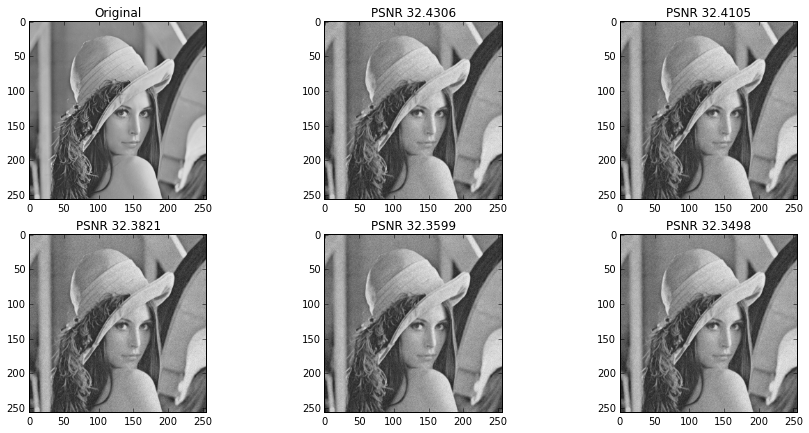

In [95]:
denoised_clustered = []
plt.figure(figsize=(15,7))
plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(lena, vmin=0, vmax=100, cmap='gray')
for i,n in enumerate(noisy):
    start = time.time()
    denoised = nonlocalmeans_clustered(noisy[2], n_neighbors=30, n_small=1, h=2*sigmas[i])
    end = time.time()
    secs = end-start
    denoised_clustered.append(denoised)
    oPSNR = PSNR(lena, noisy[i])
    dPSNR = PSNR(lena, denoised)
    print("PSNR before {0:.4f} - PSNR after denoising {1:.4f} - tool {2:.1f} secs".format(oPSNR, dPSNR, secs))
    plt.subplot(2,3,i+2)
    plt.title("PSNR {0:.4f}".format(dPSNR))
    plt.imshow(denoised, vmin=0, vmax=100, cmap='gray')

Results look much more nicer now, and definetly the time used has been greatly reduced. Let's compare both implementations

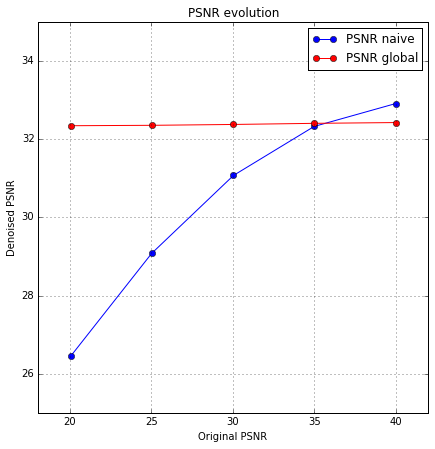

In [111]:
psnr_noisy = []
psnr_denoised_naive = []
psnr_denoised_clustered = []
for i, n in enumerate(noisy):
    psnr_noisy.append(PSNR(lena, n))
    psnr_denoised_naive.append(PSNR(lena,denoised_naive[i]))
    psnr_denoised_clustered.append(PSNR(lena,denoised_clustered[i]))
plt.figure(figsize=(7,7))
plt.grid(True)
plt.title("PSNR evolution")
plt.xlabel("Original PSNR")
plt.ylabel("Denoised PSNR")
plt.axis([18, 42, 25, 35])
plt.plot(psnr_noisy, psnr_denoised_naive, 'b-o', label="PSNR naive")
plt.plot(psnr_noisy, psnr_denoised_clustered, 'r-o', label="PSNR global")
l = plt.legend()


With the figure above it is clear the having a global aproach is beneficial, specially for low PSNRs. The only case where our PCA approximation under performs the naive algorithm is in a high PSNR regime.

For the results to be valid, we should try this in a large iamge corpus, and verify that the PCA+BallTree approach actually works better than the naive one. But it's a start.

## References

[1]: Paris, S., Kornprobst, P., Tumblin, J., & Durand, F. (2009). Bilateral filtering: Theory and applications. Now Publishers Inc.

[2]: Buades, A., Coll, B., & Morel, J. M. (2005, June). A non-local algorithm for image denoising. In Computer Vision and Pattern Recognition, 2005. CVPR 2005. IEEE Computer Society Conference on (Vol. 2, pp. 60-65). IEEE.

[3]: Rudin, L. I., Osher, S., & Fatemi, E. (1992). Nonlinear total variation based noise removal algorithms. Physica D: Nonlinear Phenomena, 60(1), 259-268.

[4]: Buades, A., Coll, B., & Morel, J. M. (2005). A review of image denoising algorithms, with a new one. Multiscale Modeling & Simulation, 4(2), 490-530.

You can find the code for this post at:
https://github.com/dsvision/nlm